In [1]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [4]:
x = os.listdir('/content/drive/My Drive/cat_dogs')
print(x)

['.DS_Store', 'train']


In [92]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
#QUESTION 1, ImageNet classes with ResNet50
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/Colab Notebooks/data1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=5)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


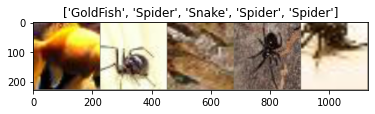

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0203 Acc: 0.6104
val Loss: 0.7969 Acc: 0.8000

Epoch 1/24
----------
train Loss: 0.8734 Acc: 0.6880
val Loss: 0.4855 Acc: 0.9000

Epoch 2/24
----------
train Loss: 0.7555 Acc: 0.7220
val Loss: 0.2552 Acc: 0.9000

Epoch 3/24
----------
train Loss: 0.7130 Acc: 0.7408
val Loss: 0.3993 Acc: 0.9000

Epoch 4/24
----------
train Loss: 0.7034 Acc: 0.7416
val Loss: 0.4335 Acc: 0.8000

Epoch 5/24
----------
train Loss: 0.6548 Acc: 0.7620
val Loss: 0.3363 Acc: 0.9000

Epoch 6/24
----------
train Loss: 0.6044 Acc: 0.7884
val Loss: 0.3851 Acc: 0.8000

Epoch 7/24
----------
train Loss: 0.5109 Acc: 0.8220
val Loss: 0.2712 Acc: 0.9000

Epoch 8/24
----------
train Loss: 0.4596 Acc: 0.8404
val Loss: 0.2560 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.4216 Acc: 0.8500
val Loss: 0.3321 Acc: 0.9000

Epoch 10/24
----------
train Loss: 0.4043 Acc: 0.8544
val Loss: 0.1295 Acc: 0.9000

Epoch 11/24
----------
train Loss: 0.4018 Acc: 0.8520
val Loss: 0.1429 Acc: 1.0000

Ep

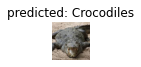

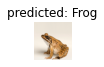

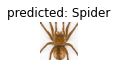

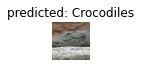

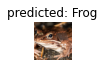

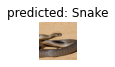

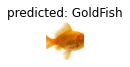

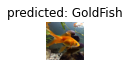

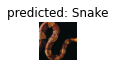

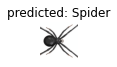

In [ ]:
visualize_model(model_ft)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy:  [1. 1. 1. 1. 1.]
f-score:  [1. 1. 1. 1. 1.]
Precision:  [1. 1. 1. 1. 1.]
Recall:  [1. 1. 1. 1. 1.]


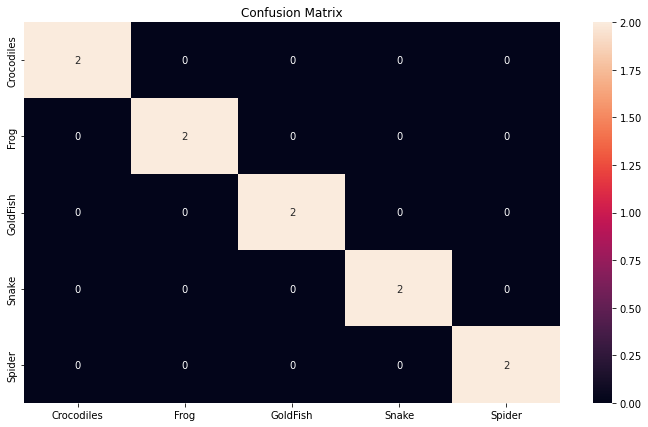

In [ ]:
# Confusion Matrix, accuracy, f-score, precision, recall
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders.get('val'):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        #output = (preds).data.cpu().numpy
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Crocodiles','Frog','GoldFish','Snake','Spider')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title('Confusion Matrix')
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
num_classes = 5
TN = []
for i in range(num_classes):
    temp = np.delete(cf_matrix, i, 0)    # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))

N = TP + FP + TN + FN
accuracy = (TP + TN) / (N * 1.0)
precision = (1.0 * TP) / (TP + FP)
recall = (1.0 * TP) / (TP + FN)
f1 = 2.0 / ((1.0 / precision) + (1.0 / recall))

print('Accuracy: ', accuracy)
print('f-score: ', precision)
print('Precision: ', recall)
print('Recall: ', f1)



In [ ]:
# QUESTION 2, MNIST classes with ResNet18
import torchvision.datasets as dset
use_cuda = torch.cuda.is_available()

root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 5

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
dataloaders = {'train':train_loader,'val':test_loader}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}
class_names = train_loader.dataset.classes
print(len(class_names))

print ('==>>> total trainning batch number: {}',format(len(train_loader)))
print ('==>>> total testing batch number: {}',format(len(test_loader)))

10
==>>> total trainning batch number: {} 12000
==>>> total testing batch number: {} 2000


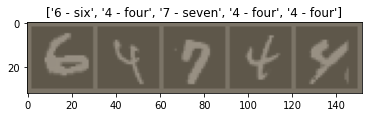

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))
dummy_RGB_images = np.ndarray(shape=(inputs.size(0), 3, inputs.size(2), inputs.size(3))) 
dummy_RGB_images[:, 0, :, :] = inputs[:, 0, :, :].data.cpu().numpy()
dummy_RGB_images[:, 1, :, :] = inputs[:, 0, :, :].data.cpu().numpy()
dummy_RGB_images[:, 2, :, :] = inputs[:, 0, :, :].data.cpu().numpy()
inputs = dummy_RGB_images
inputs = torch.from_numpy(inputs).float()
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                #print(inputs.shape)  # (64, 224, 224)
                #rgb_batch = np.repeat(inputs, 3, -1)
                #print(rgb_batch.shape)  # (64, 224, 224, 3)
                dummy_RGB_images = np.ndarray(shape=(inputs.size(0), 3, inputs.size(2), inputs.size(3))) 
                dummy_RGB_images[:, 0, :, :] = inputs[:, 0, :, :].data.cpu().numpy()
                dummy_RGB_images[:, 1, :, :] = inputs[:, 0, :, :].data.cpu().numpy()
                dummy_RGB_images[:, 2, :, :] = inputs[:, 0, :, :].data.cpu().numpy()
                inputs = dummy_RGB_images
                inputs = torch.from_numpy(inputs).cuda().float()
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            dummy_RGB_images = np.ndarray(shape=(inputs.size(0), 3, inputs.size(2), inputs.size(3))) 
            dummy_RGB_images[:, 0, :, :] = inputs[:, 0, :, :].data.cpu().numpy()
            dummy_RGB_images[:, 1, :, :] = inputs[:, 0, :, :].data.cpu().numpy()
            dummy_RGB_images[:, 2, :, :] = inputs[:, 0, :, :].data.cpu().numpy()
            inputs = dummy_RGB_images
            inputs = torch.from_numpy(inputs).float().cuda()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ftt = models.resnet18(pretrained=True)
num_ftrs = model_ftt.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ftt.fc = nn.Linear(num_ftrs, 10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ftt = model_ftt.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftt = optim.SGD(model_ftt.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ftt, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ftt = train_model(model_ftt, criterion, optimizer_ftt, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.6416 Acc: 4.5444
val Loss: 0.7284 Acc: 4.8700

Epoch 1/24
----------
train Loss: 0.4943 Acc: 4.8761
val Loss: 0.4453 Acc: 4.9365

Epoch 2/24
----------
train Loss: 0.3336 Acc: 4.9146
val Loss: 0.4990 Acc: 4.9390

Epoch 3/24
----------
train Loss: 0.2442 Acc: 4.9389
val Loss: 0.5740 Acc: 4.9125

Epoch 4/24
----------
train Loss: 0.2102 Acc: 4.9467
val Loss: 0.3446 Acc: 4.9590

Epoch 5/24
----------
train Loss: 0.1829 Acc: 4.9501
val Loss: 0.2357 Acc: 4.9595

Epoch 6/24
----------
train Loss: 0.1393 Acc: 4.9642
val Loss: 0.2595 Acc: 4.9430

Epoch 7/24
----------
train Loss: 0.0778 Acc: 4.9787
val Loss: 0.2059 Acc: 4.9660

Epoch 8/24
----------
train Loss: 0.0539 Acc: 4.9856
val Loss: 0.1710 Acc: 4.9690

Epoch 9/24
----------
train Loss: 0.0466 Acc: 4.9877
val Loss: 0.1787 Acc: 4.9640

Epoch 10/24
----------
train Loss: 0.0450 Acc: 4.9881
val Loss: 0.1541 Acc: 4.9690

Epoch 11/24
----------
train Loss: 0.0409 Acc: 4.9902
val Loss: 0.1625 Acc: 4.9655

Ep

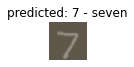

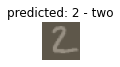

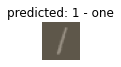

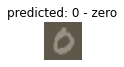

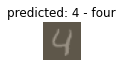

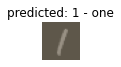

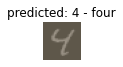

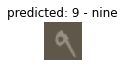

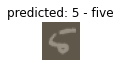

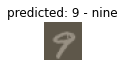

In [ ]:
visualize_model(model_ftt)

Accuracy:  [0.999  0.9992 0.9992 0.9987 0.999  0.9985 0.9988 0.9985 0.999  0.9981]
f-score:  [0.99188641 0.99300087 1.         0.99016716 0.99090909 0.99436302
 0.99684874 0.99222546 0.99588477 0.995     ]
Precision:  [0.99795918 1.         0.99224806 0.9970297  0.99898167 0.98878924
 0.99060543 0.99319066 0.99383984 0.98612488]
Recall:  [0.99491353 0.99648815 0.99610895 0.99358658 0.99492901 0.9915683
 0.99371728 0.99270783 0.99486125 0.99054256]


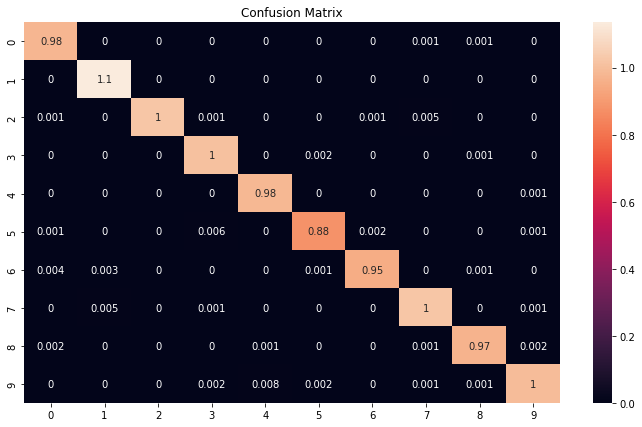

In [ ]:
 #Confusion Matrix, accuracy, f-score, precision, recall
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders.get('val'):
        inputs = inputs.to(device)
        labels = labels.to(device)
        dummy_RGB_images = np.ndarray(shape=(inputs.size(0), 3, inputs.size(2), inputs.size(3))) 
        dummy_RGB_images[:, 0, :, :] = inputs[:, 0, :, :].data.cpu().numpy()
        dummy_RGB_images[:, 1, :, :] = inputs[:, 0, :, :].data.cpu().numpy()
        dummy_RGB_images[:, 2, :, :] = inputs[:, 0, :, :].data.cpu().numpy()
        inputs = dummy_RGB_images
        inputs = torch.from_numpy(inputs).float().cuda()
        outputs = model_ftt(inputs)
        _, preds = torch.max(outputs, 1)

        output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        #output = (preds).data.cpu().numpy
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0','1','2','3','4','5','6','7','8','9')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title('Confusion Matrix')
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
num_classes = 10
TN = []
for i in range(num_classes):
    temp = np.delete(cf_matrix, i, 0)    # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))

N = TP + FP + TN + FN
accuracy = (TP + TN) / (N * 1.0)
precision = (1.0 * TP) / (TP + FP)
recall = (1.0 * TP) / (TP + FN)
f1 = 2.0 / ((1.0 / precision) + (1.0 / recall))

print('Accuracy: ', accuracy)
print('f-score: ', precision)
print('Precision: ', recall)
print('Recall: ', f1)

In [108]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

In [139]:
# QUESTION 3, Classify Dog vs Cat Kaggle
# Using first network, resnet34

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = '/content/drive/My Drive/cat_dogs/train'
#os.path.join(data_dir, x)
image_datasets = {x: datasets.ImageFolder(data_dir,
                                          data_transforms[x])
                  for x in ['train']}

train_idx, val_idx = train_test_split(list(range(len(image_datasets.get('train')))),  test_size=0.25)

mydatasets = {}
mydatasets['train'] = Subset(image_datasets['train'], np.arange(len(train_idx)))
mydatasets['val'] = Subset(image_datasets['train'], np.arange(len(val_idx)))

dataloaders = {x: torch.utils.data.DataLoader(mydatasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)

print ('==>>> total trainning batch number: {}',format(len(train_loader)))
print ('==>>> total testing batch number: {}',format(len(test_loader)))

['Cat', 'Dog']
==>>> total trainning batch number: {} 203
==>>> total testing batch number: {} 50


2


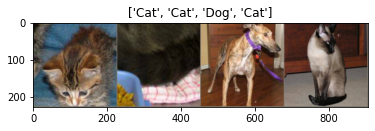

In [140]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
print(len(dataloaders))

inputss, classess = next(iter(dataloaders['train']))

# Make a grid from batch

out = torchvision.utils.make_grid(inputss)

imshow(out, title=[class_names[x] for x in classess])

In [141]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [142]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [143]:
#Network 1
model_fttt = models.resnet34(pretrained=True)
num_ftrs = model_fttt.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_fttt.fc = nn.Linear(num_ftrs, 2)

model_fttt = model_fttt.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_fttt = optim.SGD(model_fttt.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fttt, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_fttt = train_model(model_fttt, criterion, optimizer_fttt, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


In [ ]:
visualize_model(model_fttt)

In [ ]:
# Confusion Matrix, accuracy, f-score, precision, recall
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders.get('val'):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_fttt(inputs)
        _, preds = torch.max(outputs, 1)

        output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        #output = (preds).data.cpu().numpy
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Cat','Dog')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title('Confusion Matrix')
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
num_classes = 2
TN = []
for i in range(num_classes):
    temp = np.delete(cf_matrix, i, 0)    # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))

N = TP + FP + TN + FN
accuracy = (TP + TN) / (N * 1.0)
precision = (1.0 * TP) / (TP + FP)
recall = (1.0 * TP) / (TP + FN)
f1 = 2.0 / ((1.0 / precision) + (1.0 / recall))

print('Accuracy: ', accuracy)
print('f-score: ', precision)
print('Precision: ', recall)
print('Recall: ', f1)

In [ ]:
# Network 2
model_ftttt = models.resnet101(pretrained=True)
num_ftrs = model_ftttt.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ftttt.fc = nn.Linear(num_ftrs, 2)

model_ftttt = model_ftttt.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ftttt = optim.SGD(model_ftttt.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ftttt, step_size=7, gamma=0.1)

In [ ]:
model_ftttt = train_model(model_ftttt, criterion, optimizer_ftttt, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
visualize_model(model_ftttt)